<a href="https://colab.research.google.com/github/aashu-0/learn-pytorch/blob/main/02_multiclass_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Multiclass Classification**



In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# hyperparamas
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42


X_blob, y_blob = make_blobs(n_samples =1000,
                            n_features= NUM_FEATURES, # features
                            centers = NUM_CLASSES,  #labels
                            cluster_std=1.5, # give the cluster a little deviation
                            random_state= RANDOM_SEED)


# conversion into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)  #.LongTensor --> int64

X_blob[:5], y_blob[:5]

# splitting
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                            y_blob,
                                            test_size=0.2,
                                            random_state=RANDOM_SEED)

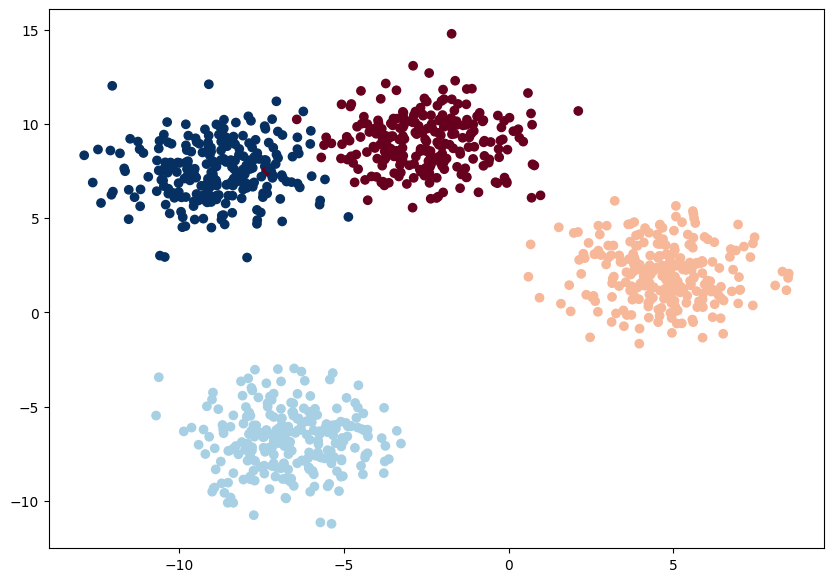

In [2]:
# plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c = y_blob, cmap= plt.cm.RdBu)

In [3]:
# setting device agostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
from torch import nn

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units= 8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features= hidden_units),
        nn.Linear(in_features=hidden_units, out_features= hidden_units),
        nn.Linear(in_features=hidden_units, out_features= output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)


model_3 = BlobModel(input_features=NUM_FEATURES,
                      output_features= NUM_CLASSES,
                    hidden_units=8).to(device)

model_3

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

for multiclass classification, we use CrossEntropyLoss()
for optimizer wee use SGD(stochastic gradient descent)

In [5]:
#create loss n accuracy fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.01)

def accuracy_fn(y_true, y_preds):
  correct = torch.eq(y_true, y_preds).sum().item()  # torch.eq() checks for equality, element-wise
  acc = (correct/len(y_preds)) * 100
  return acc


In [6]:
# predictions after single forward pass
predictions = model_3(X_blob_train.to(device))[:5]
predictions

tensor([[-0.1607,  0.1950, -0.7239,  1.4303],
        [-0.4443, -1.4437,  0.2395,  0.4501],
        [ 0.0192,  0.0846,  0.9417, -1.1891],
        [-0.0819, -0.1732,  0.6389, -0.6185],
        [-0.3864, -1.2514,  0.3245,  0.2492]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [7]:
predictions[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

raw outputs from model are called as 'logits'

for these numbers to make sense:

  ```logits --> prediction probas ---> predictions labels```


In [8]:
# predictions logits
y_logits = model_3(X_blob_test.to(device))

# perform softmax to get prediction probas
y_pred_probas = torch.softmax(y_logits, dim=1)
y_logits[:5], y_pred_probas[:5]

(tensor([[-0.2001,  0.0104, -0.6756,  1.4159],
         [-0.4386, -1.7555,  0.9029, -0.5023],
         [ 0.0145,  0.2055,  0.6647, -0.7883],
         [-0.1166,  0.2909, -0.5588,  1.1343],
         [-0.4299, -1.2297, -0.0683,  0.8684]], device='cuda:0',
        grad_fn=<SliceBackward0>),
 tensor([[0.1268, 0.1565, 0.0788, 0.6380],
         [0.1658, 0.0444, 0.6342, 0.1556],
         [0.2186, 0.2646, 0.4188, 0.0979],
         [0.1506, 0.2264, 0.0968, 0.5262],
         [0.1527, 0.0686, 0.2192, 0.5594]], device='cuda:0',
        grad_fn=<SliceBackward0>))

**Softmax Function**
* outputs values b/w 0 and 1
* sum of all outputs = 1
* transform raw outputs*(logits)* into probabilities

What this prediction probas depicts?

more the probab, more model thinks the target X sample maps to each class

In [9]:
# sum
torch.sum(y_pred_probas[0])

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)

In [10]:
print(y_pred_probas[0])
print(torch.argmax(y_pred_probas[0]))

tensor([0.1268, 0.1565, 0.0788, 0.6380], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


** to sum up:**
for a multiclass clasification problem

logits --> prediciton probab using softmax(`torch.softmax`)


Let's train the model for a multiclass classification

In [11]:
torch.manual_seed(42)

epochs = 100

# put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_3.train()


  #forward pass
  y_logits = model_3(X_blob_train)
  y_pred = torch.softmax(y_logits, dim = 1).argmax(dim=1)  # logits --> prediction probab --> prediction label

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_preds=y_pred)

  # zero grad
  optimizer.zero_grad()

  # loss backwards
  loss.backward()

  #optimizer step
  optimizer.step()

  # --TESTING--

  model_3.eval()
  with torch.inference_mode():
    #forward pass
    test_logits = model_3(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    # loss n acc
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true= y_blob_test,
                      y_preds= test_pred)

  if epoch % 10 ==0:
    print(f'Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% || Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%')


Epoch: 0 | Loss: 1.54650, Acc: 23.38% || Test Loss: 1.43414, Test Acc: 26.50%
Epoch: 10 | Loss: 0.89740, Acc: 61.38% || Test Loss: 0.86377, Test Acc: 69.50%
Epoch: 20 | Loss: 0.64290, Acc: 76.62% || Test Loss: 0.62954, Test Acc: 79.00%
Epoch: 30 | Loss: 0.49861, Acc: 92.62% || Test Loss: 0.49321, Test Acc: 95.50%
Epoch: 40 | Loss: 0.40389, Acc: 97.25% || Test Loss: 0.40207, Test Acc: 98.00%
Epoch: 50 | Loss: 0.33711, Acc: 97.50% || Test Loss: 0.33681, Test Acc: 98.00%
Epoch: 60 | Loss: 0.28779, Acc: 98.62% || Test Loss: 0.28800, Test Acc: 98.50%
Epoch: 70 | Loss: 0.25011, Acc: 98.62% || Test Loss: 0.25031, Test Acc: 99.00%
Epoch: 80 | Loss: 0.22056, Acc: 99.12% || Test Loss: 0.22050, Test Acc: 99.00%
Epoch: 90 | Loss: 0.19690, Acc: 99.12% || Test Loss: 0.19647, Test Acc: 99.00%


yay!!! pretty nice
now let's make some predictions on our trained model

In [12]:
from operator import mod
model_3.eval()
with torch.inference_mode():
  y_logits = model_3(X_blob_test)

y_logits[:10]

# predicted logits --> predicted probas --> predicted labels
y_pred_probs = torch.softmax(y_logits, dim =1)

# prediction labels
y_preds = y_pred_probs.argmax(dim=1)

print(f'Predictions {y_pred[:10]}')
print(f'Labels {y_blob_test[:10]}')

print(f'Test accuracy: {accuracy_fn(y_true=y_blob_test, y_preds=y_preds)}%')

Predictions tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0], device='cuda:0')
Labels tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.0%


Let's visualise the f'kin model !!!

In [13]:
# first let's do some copy pasta for plot_decision_boundary function

import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
   # put on cpu
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # defining range of plot on x and y axes
    # =/- 0.1 to leave a little padding for the plot

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    # creates a grid of points b/w max and min values
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    # returns two 2D arrays

    # ravel() --> unravel(or flatten the 2 array)
    # column_stack --> stackes 1d array as columns in 2d

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()



    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)


    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # reshape --> to aligns with xx, yy
    y_pred = y_pred.reshape(xx.shape).detach().numpy()


    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)

    # superimpose inital data scatter plot on top of contour plot
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

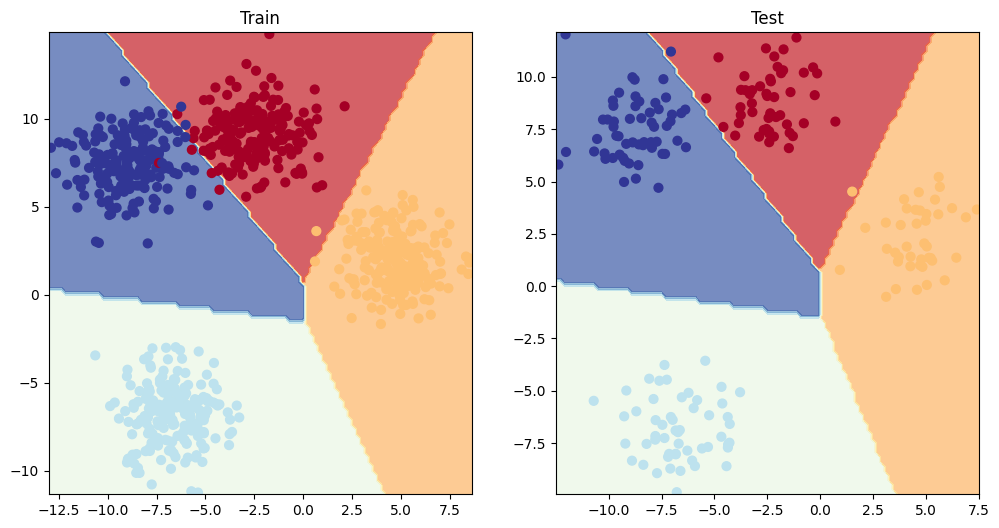

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_blob_test, y_blob_test)